In [1]:
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from torch import nn
import math
import seaborn as sns

torch.Size([10000, 2])


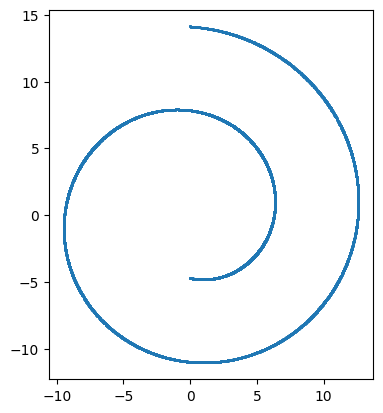

Data range: x=[-1.72, 1.61]
Data range: y=[-1.62, 2.03]


In [2]:
swiss_roll = make_swiss_roll(n_samples=10000,noise=0)[0][:,::2]
train_set = torch.tensor(swiss_roll).float()

mu, std = train_set.mean(0), train_set.std(0)
train_set = (train_set - mu)/std
print(train_set.shape)
plt.axes().set_aspect('equal')
plt.scatter(swiss_roll[:,0],swiss_roll[:,1], s=1)
plt.show()

print(f"Data range: x=[{train_set[:,0].min():.2f}, {train_set[:,0].max():.2f}]")
print(f"Data range: y=[{train_set[:,1].min():.2f}, {train_set[:,1].max():.2f}]")

loss = 1.432802: 100%|█████████████████████████████████████████| 2000/2000 [00:02<00:00, 784.83it/s]


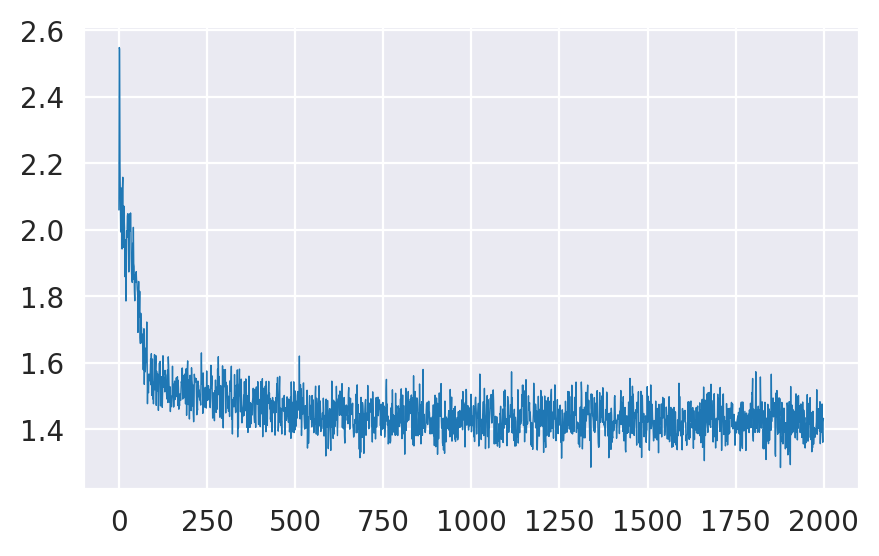

In [3]:
# Flow Matching for Generative Modeling
# https://arxiv.org/abs/2210.02747
import torch.nn.functional as F
from torch.utils.data import DataLoader



def sample_t(batch_size):
    """Sample t between 0 and 1."""
    return torch.rand(batch_size)[:,None]



def train_step(x, model, optimizer):
    """Our Path from Noise to Data is a straight line
    so the target is the speed "v" in closed form.
    Proof is in the paper
    """
    t = sample_t(len(x)).to(x.device)
    e = torch.randn_like(x)
    # here we have a convention to keep for the generator
    # if t = 0 z = x, if t = 1, x = e
    # keep this in mind, the velocity vector goes from data to noise! not the other way around
    z = (1-t) * x + t * e
    v = e - x
    u = model(z, t)
    loss = F.mse_loss(u, v)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss




class TinyMLP(nn.Module):
    """Tiny MLP Conditioned on time"""
    def __init__(self, num_in, hidden, time_dim=16):
        super(TinyMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_in + time_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, num_in)
        )
        self.time_dim = time_dim

    @staticmethod
    def time_encoding(t, d=32):
        # Sinusoidal encoding like in transformers
        freqs = torch.exp(-math.log(10000) * torch.arange(d//2, device=t.device) / (d//2))
        args = t * freqs[None, :]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x, t):
        t_enc = TinyMLP.time_encoding(t, self.time_dim)
        x_t = torch.cat((x, t_enc), dim=1)
        return self.mlp(x_t)


def train(data, model, niter, lr):
    """ To Simplify we will train with batch gradient descent
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    data = data.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    batch_size = 1000
    losses = []
    for itr in (pbar := tqdm(range(niter), ncols=100)):
        idx = torch.randperm(len(data))[:batch_size]
        x = data[idx].contiguous()
        loss = train_step(x, model, optim)
        losses.append(loss.item())
        pbar.set_description(f"loss = {loss.item():06f}")

    return losses


niter = 2000
lr = 1e-2
model = TinyMLP(2, 256, 32)
model.train()
losses = train(train_set, model, niter, lr)


with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi=200)
    ax.plot(np.arange(niter), losses, linewidth=0.5)
    plt.show()

Number of time steps: 5
Number of function evaluations: 38
Time points: [1.         0.86327923 0.43404519 0.15333476 0.        ]


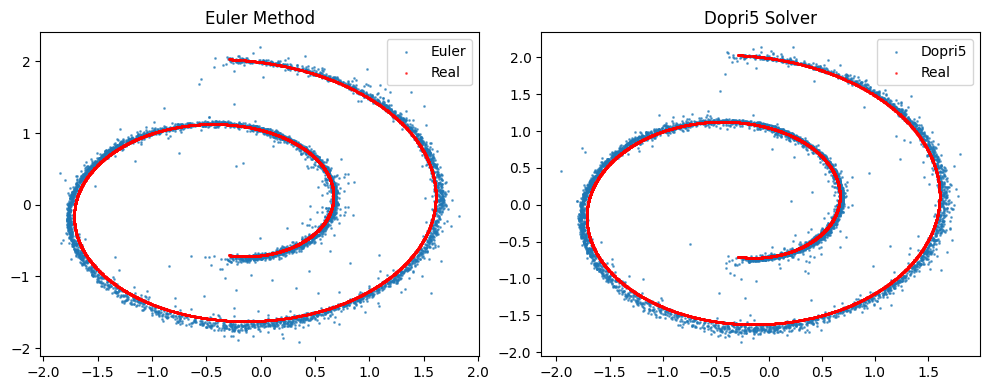

In [4]:
# let's code inference
# ivp is dopri5 ode solver
from scipy.integrate import solve_ivp


def generate_samples_euler(model, n_samples=1000, n_steps=100):
    device = next(model.parameters()).device
    z = torch.randn(n_samples, 2).to(device)
    dt = 1.0 / n_steps
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            t = torch.full((n_samples, 1), 1 - i * dt).to(device)
            v = model(z, t)
            z = z - v * dt  # Euler step
    return z.cpu()


def generate_samples_ode(model, n_samples=1000, method='RK45', rtol=1e-2, atol=1e-3):
    """ More Sophisticated ODE Integration Dopri5 "Dormand Prince" 45, a sort of
    adaptive step size Runge-Kutta
    https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method

    """
    device = next(model.parameters()).device
    z0 = torch.randn(n_samples, 2).to(device)
    model.eval()
    with torch.no_grad():
        def ode_func(t, z_flat):
            # Reshape flat array back to (n_samples, 2)
            z = torch.from_numpy(z_flat.reshape(n_samples, 2)).float().to(device)
            t_tensor = torch.full((n_samples, 1), t).to(device)

            # Get velocity from model
            v = model(z, t_tensor)

            # Return as flat numpy array
            return v.cpu().numpy().flatten()

        solution = solve_ivp(
            ode_func,
            t_span=[1, 0],
            y0=z0.cpu().numpy().flatten(),
            method=method,  # 'DOP853' is 8th order Dormand-Prince
            rtol=rtol,      # Relative tolerance
            atol=atol       # Absolute tolerance
        )
        z_final = solution.y[:, -1].reshape(n_samples, 2)

        print(f"Number of time steps: {len(solution.t)}")
        print(f"Number of function evaluations: {solution.nfev}")
        print(f"Time points: {solution.t}")

    return torch.from_numpy(z_final)


samples_euler = generate_samples_euler(model, 5000)
samples_ode = generate_samples_ode(model, 5000)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(samples_euler[:, 0], samples_euler[:, 1], alpha=0.6, s=1, label='Euler')
plt.scatter(train_set[:, 0], train_set[:, 1], alpha=0.6, s=1, color='red', label='Real')
plt.legend()
plt.title('Euler Method')

plt.subplot(1, 2, 2)
plt.scatter(samples_ode[:, 0], samples_ode[:, 1], alpha=0.6, s=1, label='Dopri5')
plt.scatter(train_set[:, 0], train_set[:, 1], alpha=0.6, s=1, color='red', label='Real')
plt.legend()
plt.title('Dopri5 Solver')
plt.tight_layout()
plt.show()

/tmp/ipykernel_31196/2713035328.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter([], [], s=12, alpha=0.8, cmap='viridis', label='Generated')


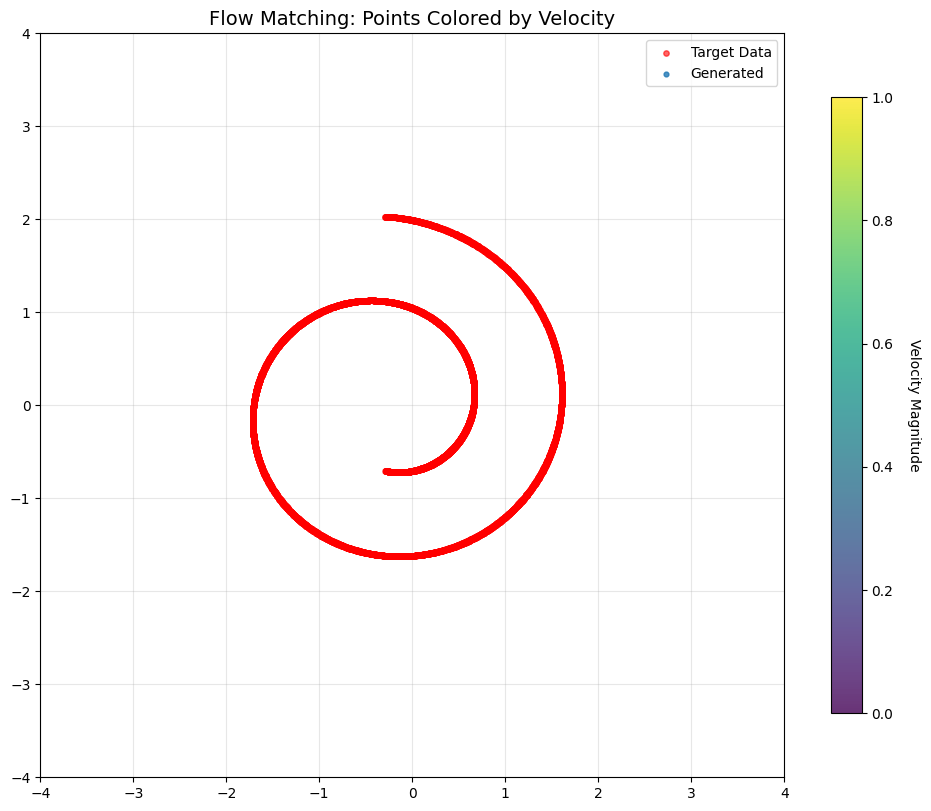

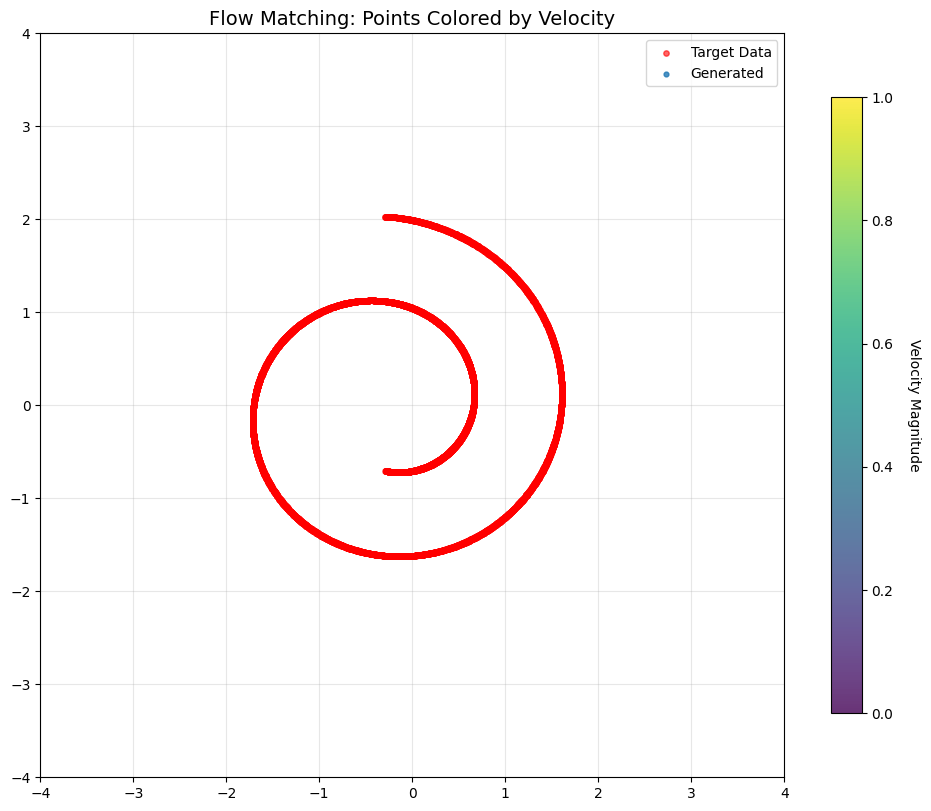

In [7]:
from matplotlib.animation import FuncAnimation

# let's show an animation of noise morphing to data
def generate_samples_euler_collect(model, n_samples=1000, n_steps=100):
    device = next(model.parameters()).device
    z = torch.randn(n_samples, 2).to(device)
    dt = 1.0 / n_steps
    model.eval()
    zis = []
    vis = []
    with torch.no_grad():
        for i in range(n_steps):
            t = torch.full((n_samples, 1), 1 - i * dt).to(device)
            v = model(z, t)
            z = z - v * dt  # Euler step
            zis.append(z.cpu().numpy())
            vis.append(v.cpu().numpy())

    return zis, vis

def animate_flow(model, n_samples=1000, n_steps=50, interval=100):
    zis, vis = generate_samples_euler_collect(model, n_samples, n_steps)

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    # Real data
    real_data = train_set.cpu().numpy() if hasattr(train_set, 'cpu') else train_set
    ax.scatter(real_data[:, 0], real_data[:, 1],
              c='red', alpha=0.6, s=15, label='Target Data', zorder=5)

    # Generated samples (will be colored by velocity)
    scat = ax.scatter([], [], s=12, alpha=0.8, cmap='viridis', label='Generated')

    # Colorbar
    cbar = plt.colorbar(scat, ax=ax, shrink=0.8)
    cbar.set_label('Velocity Magnitude', rotation=270, labelpad=20)

    title = ax.set_title('Flow Matching: Points Colored by Velocity', fontsize=14)
    ax.legend()

    def animate(frame):
        current_t = 1 - frame / n_steps

        # Update positions and colors
        current_points = zis[frame]
        current_velocities = vis[frame]
        velocity_magnitudes = np.linalg.norm(current_velocities, axis=1)

        scat.set_offsets(current_points)
        scat.set_array(velocity_magnitudes)

        title.set_text(f'Flow Matching: t={current_t:.3f} (Step {frame}/{n_steps})')

        return scat, title

    anim = FuncAnimation(fig, animate, frames=n_steps,
                        interval=interval, blit=False, repeat=True)
    return anim

# Color-coded version
anim_colored = animate_flow(model, n_samples=2000, n_steps=50, interval=150)
plt.show()

anim = animate_flow(model, n_samples=2000, n_steps=50, interval=150)
plt.show()
anim.save('flow_matching_animation.gif', writer='pillow', fps=7)